In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

sns.set_theme(style="darkgrid")
p = '/home/pelle/Master_Thesis/data/raw/DTU_2015-01-01-2022-01-01'
df=pd.read_csv(p+"/DTU_posts.csv")
df.columns = ['author','created_utc','domain','id','score','n_comments','text','title','url','date']
df_comments=pd.read_csv(p+"/DTU_comments.csv")

if 'author' not in df_comments.columns:
    df_comments.columns = ['author','text','created_utc','id','parent_id','score','subreddit','created']

#convert to datetime
df['date'] = pd.to_datetime(df['date'],unit='s')
# df_comments['created'] = pd.to_datetime(df_comments['created'],unit='s')

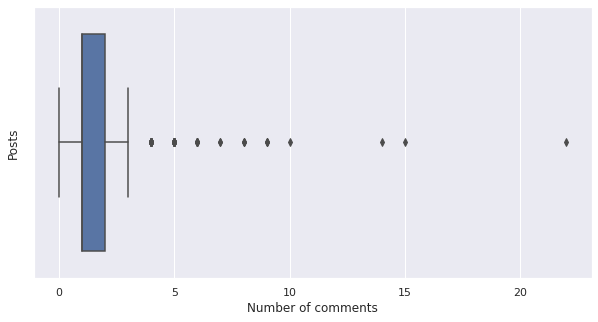

Mean:  1.9134808853118712
Median:  1.0
Max:  22
Min:  0
Std:  1.9455772876010184
Var:  3.7852709820289356


In [25]:
def plot_comments_per_post(df):
    plt.figure(figsize=(10,5))
    ax = sns.boxplot(x=df["n_comments"])
    ax.set(xlabel='Number of comments', ylabel='Posts')
    plt.show()
    print("Mean: ", np.mean(df["n_comments"]))
    print("Median: ", np.median(df["n_comments"]))
    print("Max: ", np.max(df["n_comments"]))
    print("Min: ", np.min(df["n_comments"]))
    print("Std: ", np.std(df["n_comments"]))
    print("Var: ", np.var(df["n_comments"]))

plot_comments_per_post(df)

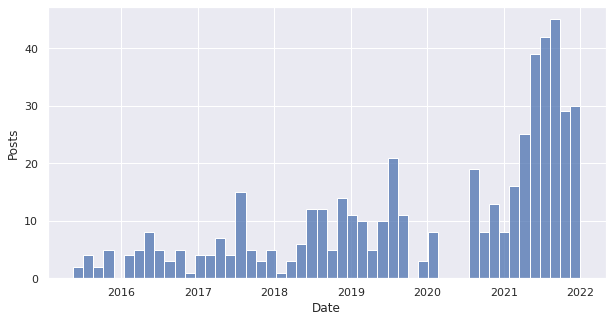

In [26]:
def plot_post_date(df):
    plt.figure(figsize=(10,5))
    ax = sns.histplot(x=df["date"],bins=50)
    ax.set(xlabel='Date', ylabel='Posts')
    plt.show()

plot_post_date(df)

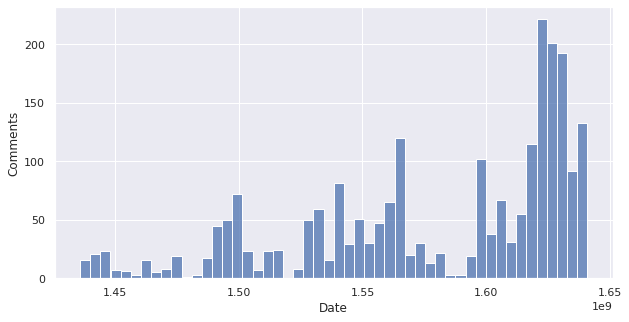

In [27]:
def plot_comments_in_df_comments(df_comments):
    plt.figure(figsize=(10,5))
    ax = sns.histplot(x=df_comments["created"],bins=50)
    ax.set(xlabel='Date', ylabel='Comments')
    plt.show()

plot_comments_in_df_comments(df_comments)

In [28]:
df_all_nodes = pd.DataFrame()
df_all_nodes['author'] = pd.concat([df_comments["author"].drop_duplicates(), df["author"].drop_duplicates()])
df_all_nodes = df_all_nodes.drop_duplicates()

def find_type(author):
    if author in df["author"].unique():
        if author in df_comments["author"].unique():
            return "both"
        else:
            return "poster"
    else:
        return "commenter"

df_all_nodes["type"] = df_all_nodes["author"].apply(find_type)

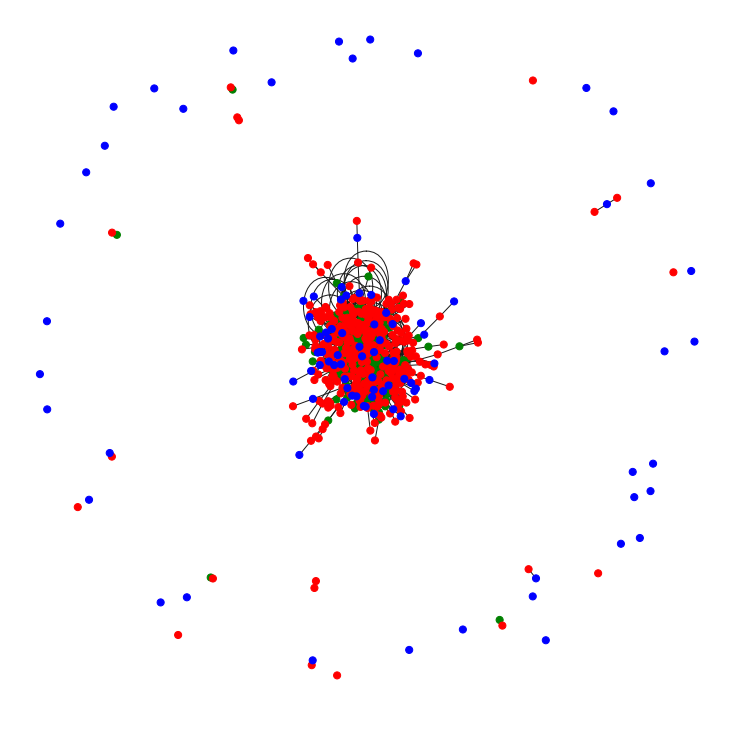

In [57]:
# add nodes from authors
G = nx.Graph()

df_all_nodes["author"].dropna(inplace=True)
G.add_nodes_from(df_all_nodes["author"].loc[df_all_nodes['type']=='both'], type='both')
G.add_nodes_from(df_all_nodes["author"].loc[df_all_nodes['type']=='commenter'], type='commenter')
G.add_nodes_from(df_all_nodes["author"].loc[df_all_nodes['type']=='poster'], type='poster')

color_map = []
for node in G:
    if type(node) == float: print('node is float!')

    if G.nodes[node]['type'] == 'both': color_map.append('green')
    elif G.nodes[node]['type'] == 'commenter': color_map.append('red')
    else: color_map.append('blue')

    for p_id in df_comments.loc[df_comments['author'] == node].parent_id:
        if len(list(p_id)) > 0:
            if 't3_' in p_id:
                p_id = p_id.replace('t3_','')
                if p_id in df['id'].unique():
                    if df.loc[df['id'] == p_id].author.values[0] in G.nodes:

                        if G.has_edge(node, df.loc[df['id'] == p_id].author.values[0]): w = w + 1
                        else: w = 1
                        
                        G.add_edge(node, df.loc[df['id'] == p_id].author.values[0], weight=w)
            
            elif 't1_' in p_id:
                p_id = p_id.replace('t1_','')
                if p_id in df_comments['id'].unique():
                    if df_comments.loc[df_comments['id'] == p_id].author.values[0] in G.nodes:

                        if G.has_edge(node, df_comments.loc[df_comments['id'] == p_id].author.values[0]): 
                            w_c = G.edges[node, df_comments.loc[df_comments['id'] == p_id].author.values[0]]['weight']
                            w = w_c + 1
                        else: w = 1

                        G.add_edge(node, df_comments.loc[df_comments['id'] == p_id].author.values[0], weight=w)

# color node
plt.figure(figsize=(10,10))
nx.draw(G, node_color=color_map, with_labels=False, node_size=50,pos=nx.spring_layout(G))

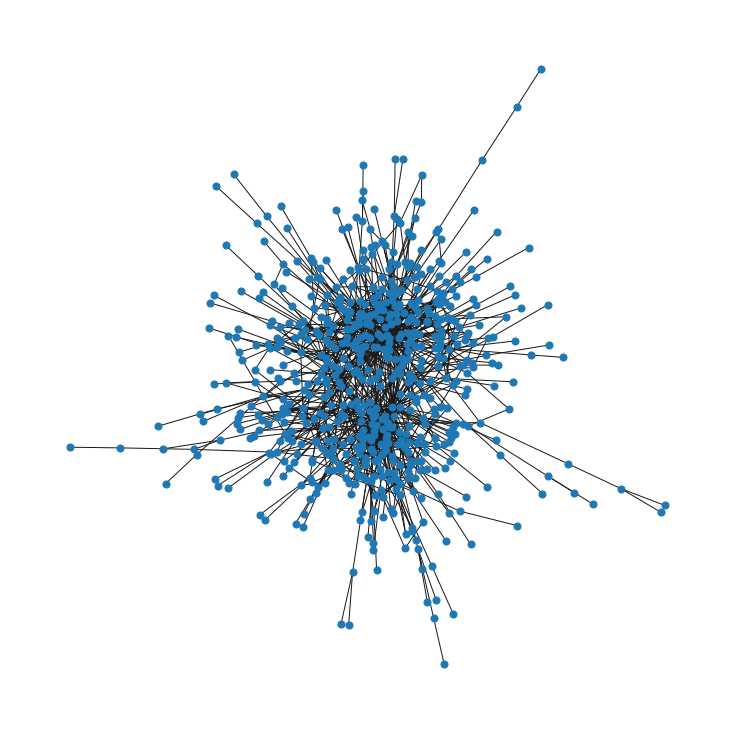

In [39]:
G2 = G.copy()
G2.remove_edges_from(nx.selfloop_edges(G2))
G2 = [G2.subgraph(cc) for cc in nx.connected_components(G2)][0]

plt.figure(figsize=(10,10))
nx.draw(G2, with_labels=False, node_size=50,pos=nx.spring_layout(G2))

In [40]:
# get edge attributes
edge_weights = []
for edge in G.edges:
    edge_weights.append(G.edges[edge]['weight'])

edge_weights = np.array(edge_weights)
print(edge_weights.mean())

# get edge attributes
edge_weights = []
for edge in G2.edges:
    edge_weights.append(G2.edges[edge]['weight'])

edge_weights = np.array(edge_weights)
print(edge_weights.mean())

2.0241465445462117
2.0430292598967297


In [58]:
# get edge attributes
edge_weights = []
for edge in G.edges:
    edge_weights.append(G.edges[edge]['weight'])

edge_weights = np.array(edge_weights)
print(edge_weights.mean())

# get edge attributes
edge_weights = []
for edge in G2.edges:
    edge_weights.append(G2.edges[edge]['weight'])

edge_weights = np.array(edge_weights)
print(edge_weights.mean())

1.9475437135720233
2.0430292598967297


In [45]:
# get sepcific edge between two nodes
G2.edges['global_engineer','Austgeo']

KeyError: 'Key Austgeo not found'

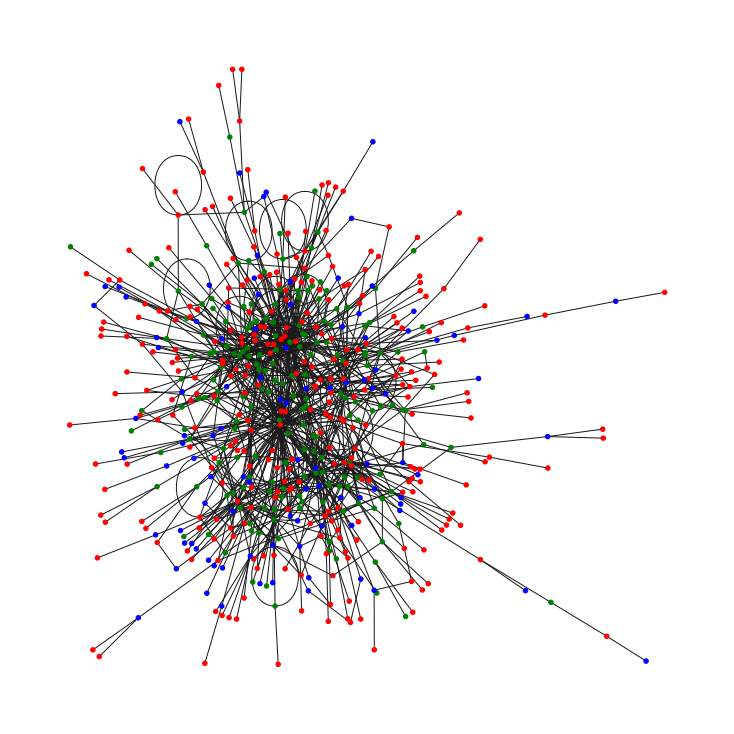

In [9]:
# copy graph
G2 = G.copy()

for component in list(nx.connected_components(G2)):
    if len(component)<6:
        for node in component:
            G2.remove_node(node)

# color nodes by type
color_map2 = []
for node in G2:
    if G2.nodes[node]['type'] == 'both':
        color_map2.append('green')
    elif G2.nodes[node]['type'] == 'commenter':
        color_map2.append('red')
    else:
        color_map2.append('blue')


# increase size of nodes depending on degree
node_size = [G2.degree(node)*10+100 for node in G2]


# plot graph
plt.figure(figsize=(10,10))
nx.draw(G2, node_color=color_map2, with_labels=False,node_size=20, pos=nx.spring_layout(G2))


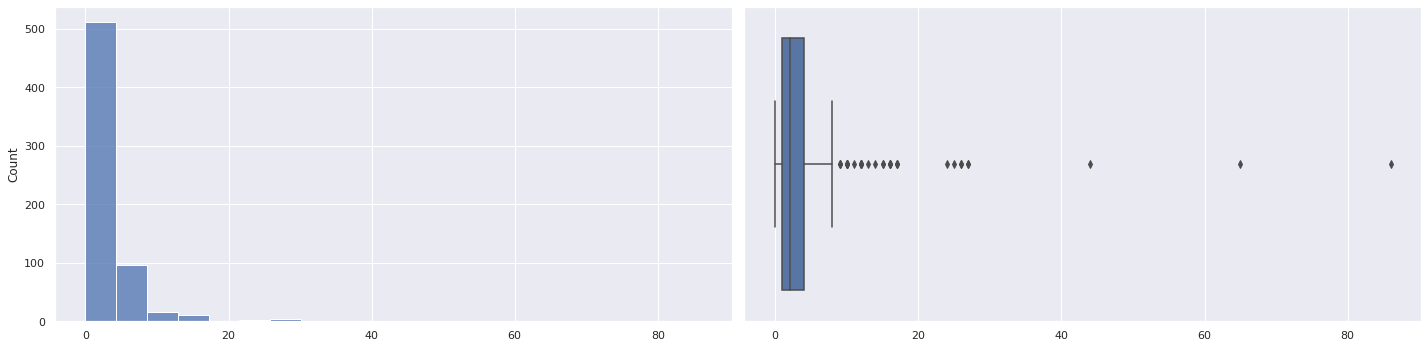

In [8]:
# plot subplots of degrees boxplot and distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(x=list(dict(G.degree()).values()),bins=20, ax=ax1)
sns.boxplot(x=list(dict(G.degree()).values()), ax=ax2)
plt.tight_layout()
plt.show()